# DeepLabCut Ingestion/Inference

# DeepLabCut manual:
https://github.com/DeepLabCut/DeepLabCut/blob/main/docs/standardDeepLabCut_UserGuide.md

`Dev notes:` Currently, the path structure assumes you have one DLC project directory for all models, as specified within `adamacs.pipeline.get_dlc_root_data_dir`. The parallel function `get_dlc_processed_data_dir` can specify the output directory. 

## TODO

1. Have the DLC model as selector in the Pingest GUI (model.Model() = model_name)
2. Add a checkbox to process DLC data
3. model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True}, task_mode = 'trigger') - have additional options in table?
4. model.RecordingInfo.populate()
model.RecordingInfo()
5. model.PoseEstimation.populate()
6. defer population to tmux or cron jobs?


## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()

[2023-07-28 10:54:52,251][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-07-28 10:54:52,301][INFO]: Connected tobiasr@172.26.128.53:3306


DataJoint connection (connected) tobiasr@172.26.128.53:3306

In [2]:
dj.config["custom"].get("dlc_root_data_dir")


['/datajoint-data/data/tobiasr/DeepLabCutModels/DB_DLC_tracking',
 '/datajoint-data/data/tobiasr/DeepLabCutModels/NK_DLC_tracking',
 '/']

### Imports and activation

Importing schema from `adamacs.pipeline` automatically activates items.

In [3]:
from adamacs.pipeline import subject, train,  scan, event, trial, behavior, session, model, equipment

## Ingesting videos and training parameters

### Automated

Refer the `user_data` folder in the `adamacs` directory contains CSVs for inserting values into DeepLabCut tables.

1. `config_params.csv` is used for training parameter sets in `train.TrainingParamSet`. The following items are required, but others will also be passed to DLC's `train_network` function when called 
2. `train_videosets.csv` and `model_videos.csv` pass values to `train.VideoSet` and `model.VideoRecording` respectively.
3. `adamacs.ingest.dlc.ingest_dlc_items` will load each of these CSVs

For more information, see [this notebook](https://github.com/CBroz1/workflow-deeplabcut/blob/main/notebooks/04-Automate_Optional.ipynb)

In [ ]:
    # from adamacs.ingest.dlc import ingest_dlc_items
    # ingest_dlc_items()

In [ ]:
model.VideoRecording().delete()
model.Model.delete()

In [ ]:
train.schema.list_tables()

In [ ]:
model.schema.list_tables()

### Manual

The same training parameters as above can be manually inserted as follows.

In [ ]:
import yaml
from element_interface.utils import find_full_path
from adamacs.paths import get_dlc_root_data_dir
import pathlib
config_path = find_full_path(get_dlc_root_data_dir(), 
                             'from_top_tracking-DJ-2022-02-23/config.yaml')
config_path

In [ ]:
model.VideoRecording.delete()

In [ ]:
scansi = "scan9FJ842C3"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4*"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 0})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [ ]:
scansi = "scan9FB2LN5C"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4*"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 1})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [ ]:
scansi = "scan9FHELAYA"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*copy*.mp4"))[0])
# moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4-copy.mp4"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 2})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [ ]:
model.VideoRecording() * model.VideoRecording.File() * equipment.Device()

## Model Training

The `TrainingTask` table queues up training. To launch training from a different machine, one needs to edit DLC's config files to reflect updated paths. For training, this includes `dlc-models/*/*/train/pose_cfg.yaml`

`CB DEV NOTE:` I'm missing the following videos used to originally train the model:
- top_video2022-02-17T15_56_10.mp4
- top_video2022-02-21T12_18_09.mp4

#### DeepLabcut Tables

The `VideoSet` table in the `train` schema retains records of files generated in the video labeling process (e.g., `h5`, `csv`, `png`). DeepLabCut will refer to the `mat` file located under the `training-datasets` directory.

We recommend storing all paths as relative to the root in your config.

In [ ]:
train.VideoSet.delete()

In [ ]:
train.VideoSet.insert1({'video_set_id': 0}, skip_duplicates=True)
project_folder = 'from_top_tracking-DJ-2022-02-23/'
training_files = ['labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.h5',
                  'labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.csv',
                  'labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/img00674.png',
                  'videos/exp9FANLWRZ_top_video2022-02-21T12_18_09.mp4']
for idx, filename in enumerate(training_files):
    train.VideoSet.File.insert1({'video_set_id': 0,
                                 'file_id': idx,
                                 'file_path': (project_folder + filename)}, skip_duplicates=True)
train.VideoSet.File()

In [ ]:
train.VideoSet.insert1({'video_set_id': 1}, skip_duplicates=True)
project_folder = 'Head_orientation-NK-2023-07-17/'
training_files = ['labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.h5',
                  'labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.csv',
                  'labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/img00162.png',
                  'videos/scan9FHF1JT7_top_video_2023-04-06T09_31_19.mp4']
for idx, filename in enumerate(training_files):
    train.VideoSet.File.insert1({'video_set_id': 1,
                                 'file_id': idx,
                                 'file_path': (project_folder + filename)}, skip_duplicates=True)
train.VideoSet.File()

The `params` longblob should be a dictionary that captures all items for DeepLabCut's `train_network` function. At minimum, this is the contents of the project's config file, as well as `suffle` and `trainingsetindex`, which are not included in the config. 

In [ ]:
from deeplabcut import train_network
help(train_network) # for more information on optional parameters

Here, we give these items, load the config contents, and overwrite some defaults, including `maxiters`, to restrict our training iterations to 5.

In [ ]:
train.TrainingParamSet()

In [ ]:
import yaml

paramset_idx = 0; paramset_desc='from_top_tracking-DJ-2022-02-23'

config_path = find_full_path(get_dlc_root_data_dir()[0], 
                             paramset_desc + '/config.yaml')

with open(config_path, 'rb') as y:
    config_params = yaml.safe_load(y)
training_params = {'shuffle': '1',
                   'trainingsetindex': '0',
                   'maxiters': '5',
                   'scorer_legacy': 'False',
                   'maxiters': '5', 
                   'multianimalproject':'False'}
config_params.update(training_params)
train.TrainingParamSet.insert_new_params(paramset_idx=paramset_idx,
                                         paramset_desc=paramset_desc,
                                         params=config_params)

In [ ]:
paramset_idx = 1; paramset_desc='Head_orientation-NK-2023-07-17'

config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')

with open(config_path, 'rb') as y:
    config_params = yaml.safe_load(y)
training_params = {'shuffle': '1',
                   'trainingsetindex': '0',
                   'maxiters': '5',
                   'scorer_legacy': 'False',
                   'maxiters': '5', 
                   'multianimalproject':'False'}
config_params.update(training_params)
train.TrainingParamSet.insert_new_params(paramset_idx=paramset_idx,
                                         paramset_desc=paramset_desc,
                                         params=config_params)

In [ ]:
train.TrainingParamSet()

In [ ]:
# train.TrainingTask.delete()

In [ ]:
key={'video_set_id': 0, 
     'paramset_idx':0,
     'training_id':0, # uniquely defines training task
     'project_path':'from_top_tracking-DJ-2022-02-23/' # relative to dlc_root in dj.config
    }
train.TrainingTask.insert1(key, skip_duplicates=True)
train.TrainingTask()

In [ ]:
key={'video_set_id': 1, 
     'paramset_idx':1,
     'training_id':1, # uniquely defines training task
     'project_path':'Head_orientation-NK-2023-07-17' # relative to dlc_root in dj.config
    }
train.TrainingTask.insert1(key, skip_duplicates=True)
train.TrainingTask()

In [ ]:
(train.TrainingParamSet & "paramset_idx=1").fetch("params")

In [ ]:
# (train.TrainingTask() & ("video_set_id = 1")).delete()
train.TrainingTask()

In [ ]:
train.ModelTraining.populate()

In [ ]:
train.ModelTraining()

To start training from a previous instance, one would need to 
[edit the relevant config file](https://github.com/DeepLabCut/DeepLabCut/issues/70) and
adjust the `maxiters` paramset (if present) to a higher threshold (e.g., 10 for 5 more itterations).
Emperical work from the Mathis team suggests 200k iterations for any true use-case.

## Tracking Joints/Body Parts

The `model` schema uses a lookup table for managing Body Parts tracked across models.

In [ ]:
model.Model()

In [ ]:
model.BodyPart.heading

This table is equipped with two helper functions. First, we can identify all the new body parts from a given config file.

In [ ]:
from adamacs.paths import get_dlc_root_data_dir
config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')
model.BodyPart.extract_new_body_parts(config_path)

Now, we can make a list of descriptions in the same order, and insert them into the table

In [ ]:
model.BodyPart()

In [ ]:
# Will be inserted with model insertion
# bp_desc=['Body Center', 'Head', 'Base of Tail']
# model.BodyPart.insert_from_config(config_path,bp_desc)

If we skip this step, body parts (without descriptions) will be added when we insert a model. We can [update](https://docs.datajoint.org/python/v0.13/manipulation/3-Cautious-Update.html) empty descriptions at any time.

## Declaring a Model

If training appears successful, the result can be inserted into the `Model` table for automatic evaluation.

In [ ]:
paramset_desc='from_top_tracking-DJ-2022-02-23'

config_path = find_full_path(get_dlc_root_data_dir()[0], 
                             paramset_desc + '/config.yaml')

In [ ]:
model.Model.insert_new_model(model_name='from_top_tracking-DJ',dlc_config=config_path,
                             shuffle=1,trainingsetindex=0,
                             model_description='From Top, trained 5 iterations',
                             paramset_idx=0)

In [ ]:
paramset_desc='Head_orientation-NK-2023-07-17'

config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')

In [ ]:
model.Model.insert_new_model(model_name='Head_orientation-NK',dlc_config=config_path,
                             shuffle=1,trainingsetindex=0,
                             model_description='From Top, trained 5 iterations',
                             paramset_idx=1)

In [ ]:
model.Model()

In [ ]:
model.VideoRecording * model.VideoRecording.File()

In [ ]:
model.Model().fetch("config_template")

In [ ]:
model.Model.BodyPart()

## Model Evaluation

Next, all inserted models can be evaluated with a similar `populate` method, which will
insert the relevant output from DLC's `evaluate_network` function.

In [ ]:
model.ModelEvaluation.heading

In [ ]:
model.ModelEvaluation.populate()

If your project was initialized in a version of DeepLabCut other than the one you're currently using, model evaluation may report key errors. Specifically, your `config.yaml` may not specify `multianimalproject: false`.

In [ ]:
model.ModelEvaluation()

In [ ]:
model.RecordingInfo.populate()
model.RecordingInfo() * model.VideoRecording.File()

## Pose Estimation

In [ ]:
scansi = "scan9FHF1SXZ"
scan_key = (model.VideoRecording.File & f'recording_id = "{scansi}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

In [ ]:
model.VideoRecording.File()

For demonstration purposes, we'll make a shorter video that will process relatively quickly `ffmpeg`, a DLC dependency ([more info here](https://github.com/datajoint/workflow-deeplabcut/blob/main/notebooks/00-DataDownload_Optional.ipynb))

In [ ]:
from adamacs.paths import get_dlc_root_data_dir
vid_path =  find_full_path(get_dlc_root_data_dir(), path[0][1::])
print(vid_path)
starttime = 0
duration = 10
cmd = (f'ffmpeg -n -hide_banner -loglevel error -ss {starttime} -t {duration} -i {vid_path} '
       + f'-vcodec copy -acodec copy {vid_path}-copy.mp4')
import os; os.system(cmd)

In [ ]:
model.VideoRecording.delete()

Next, we need to specify if the `PoseEstimation` table should load results from an existing file or trigger the estimation command. Here, we can also specify parameters accepted by the `analyze_videos` function as a dictionary. `task_mode` determines if pose estimation results should be loaded or triggered (i.e., load vs. trigger).

In [ ]:
key = (model.VideoRecording & {'recording_id': 'scan9FHF1SXZ'}).fetch1('KEY')
key.update({'model_name': 'Head_orientation-NK', 'task_mode': 'trigger'})
key



The `PoseEstimationTask` table queues items for pose estimation. Additional parameters are passed to DLC's `analyze_videos` function.

In [ ]:
# model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True})
model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True, 'dynamic':(True,.5,100)}) # dynamic cropping

In [ ]:
model.RecordingInfo.populate()
model.RecordingInfo()

In [ ]:
model.PoseEstimation.populate()

In [ ]:
model.PoseEstimationTask().delete()
model.PoseEstimation().delete()

# Data Evaluation

By default, DataJoint will store the results of pose estimation in a subdirectory
>  processed_dir / videos / device_<#>_recording_<#>_model_<name>

Pulling processed_dir from `get_dlc_processed_dir`, and device/recording information 
from the `VideoRecording` table. The model name is taken from the primary key of the
`Model` table, with spaced replaced by hyphens.
    
We can get this estimation directly as a pandas dataframe.

In [17]:
model.PoseEstimation.BodyPartPosition() 

session_id,recording_id,model_name User-friendly model name,body_part,frame_index frame index in model,x_pos,y_pos,z_pos,likelihood
sess9FHF1JT7,scan9FHF1JT7,Head_orientation-NK,body_middle,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHF1JT7,scan9FHF1SXZ,Head_orientation-NK,body_middle,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHF1JT7,scan9FHF202P,Head_orientation-NK,body_middle,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHF1JT7,scan9FHF1JT7,Head_orientation-NK,head_middle,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHF1JT7,scan9FHF1SXZ,Head_orientation-NK,head_middle,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHF1JT7,scan9FHF202P,Head_orientation-NK,head_middle,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHF1JT7,scan9FHF1JT7,Head_orientation-NK,left_ear,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHF1JT7,scan9FHF1SXZ,Head_orientation-NK,left_ear,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHF1JT7,scan9FHF202P,Head_orientation-NK,left_ear,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHF1JT7,scan9FHF1JT7,Head_orientation-NK,neck,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [18]:
scansi = "scan9FHF202P"
scan_key = (model.PoseEstimation & f'recording_id = "{scansi}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

array(['/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-06_scan9FHF202P_sess9FHF1JT7/scan9FHF202P_top_video_2023-04-06T10_01_37.mp4'],
      dtype=object)

In [19]:
model.PoseEstimation.get_trajectory(scan_key)

scorer    Head_orientation-NK                                           
bodyparts         body_middle                             head_middle   
coords                      x           y    z likelihood           x   
0                   89.312053  503.848127  0.0   0.996124   75.570070  \
1                   89.494016  513.413475  0.0   0.995227   77.561444   
2                   84.982279  524.261390  0.0   0.977547   75.267134   
3                   83.256537  538.717690  0.0   0.957298   75.208024   
4                   83.707059  546.826303  0.0   0.938999   77.474673   
...                       ...         ...  ...        ...         ...   
36126              723.692474  880.993918  0.0   0.999733  767.299920   
36127              723.515416  880.362966  0.0   0.999849  765.177024   
36128              724.142204  882.996995  0.0   0.999704  767.323281   
36129              723.520252  882.361722  0.0   0.999852  765.138567   
36130              725.652025  882.408289  0.0   0.999863  766.892200   

scorer                                                         ...        
bodyparts                                left_ear              ... nose   
coords              y    z likelihood           x           y  ...    z   
0          585.137072  0.0   0.046164   89.296142  576.613781  ...  0.0  \
1          589.287371  0.0   0.028345   88.959346  586.104636  ...  0.0   
2          596.538025  0.0   0.013343   89.984062  594.053309  ...  0.0   
3          604.329567  0.0   0.271816   88.119644  608.998556  ...  0.0   
4          610.870860  0.0   0.134685   86.462664  613.377447  ...  0.0   
...               ...  ...        ...         ...         ...  ...  ...   
36126      854.695577  0.0   0.847780  743.868963  839.931814  ...  0.0   
36127      849.754143  0.0   0.928634  741.084880  840.238615  ...  0.0   
36128      856.458844  0.0   0.812338  743.295485  841.987622  ...  0.0   
36129      851.794667  0.0   0.934287  741.101342  842.314914  ...  0.0   
36130      852.910056  0.0   0.887226  742.334903  841.271572  ...  0.0   

scorer                                                                     
bodyparts              right_ear                                    tail   
coords    likelihood           x           y    z likelihood           x   
0           0.111172  105.102160  494.470958  0.0   0.021652   91.645957  \
1           0.056283  101.392357  489.534656  0.0   0.073973   90.961860   
2           0.071481   94.162769  506.047390  0.0   0.023707   92.193787   
3           0.184839   69.283525  571.517355  0.0   0.005808   89.103902   
4           0.125479   66.578255  596.074324  0.0   0.009130   92.398115   
...              ...         ...         ...  ...        ...         ...   
36126       0.033176  769.842113  881.260251  0.0   0.948618  699.078765   
36127       0.056457  768.692274  873.840552  0.0   0.920087  699.171469   
36128       0.056192  769.114733  883.036491  0.0   0.955663  699.411177   
36129       0.058983  768.737617  875.896014  0.0   0.919510  699.269232   
36130       0.123383  770.438249  878.245699  0.0   0.913810  701.044294   

scorer                                 
bodyparts                              
coords              y    z likelihood  
0          469.588874  0.0   0.999352  
1          479.004118  0.0   0.998526  
2          486.675381  0.0   0.996328  
3          617.215758  0.0   0.698225  
4          623.458826  0.0   0.553697  
...               ...  ...        ...  
36126      890.077041  0.0   0.999845  
36127      890.349172  0.0   0.999286  
36128      891.791734  0.0   0.999898  
36129      892.361501  0.0   0.999304  
36130      892.300975  0.0   0.999149  

[36131 rows x 28 columns]

In [20]:
(model.PoseEstimation.BodyPartPosition() & scan_key & 'body_part = "head_middle"').fetch("x_pos", "y_pos")

[array([array([ 75.5700697 ,  77.56144428,  75.26713419, ..., 767.32328081,
               765.13856745, 766.89220023])                                ],
       dtype=object),
 array([array([585.13707161, 589.28737104, 596.5380249 , ..., 856.45884356,
               851.79466653, 852.91005635])                                ],
       dtype=object)]

In [21]:
#reduce dataframe to xy coordinates
df=model.PoseEstimation.get_trajectory(scan_key)
df_xy = df.iloc[:,df.columns.get_level_values(2).isin(["x","y"])]['Head_orientation-NK']
# df_xy.mean()
df_xy

bodyparts body_middle             head_middle                left_ear   
coords              x           y           x           y           x   
0           89.312053  503.848127   75.570070  585.137072   89.296142  \
1           89.494016  513.413475   77.561444  589.287371   88.959346   
2           84.982279  524.261390   75.267134  596.538025   89.984062   
3           83.256537  538.717690   75.208024  604.329567   88.119644   
4           83.707059  546.826303   77.474673  610.870860   86.462664   
...               ...         ...         ...         ...         ...   
36126      723.692474  880.993918  767.299920  854.695577  743.868963   
36127      723.515416  880.362966  765.177024  849.754143  741.084880   
36128      724.142204  882.996995  767.323281  856.458844  743.295485   
36129      723.520252  882.361722  765.138567  851.794667  741.101342   
36130      725.652025  882.408289  766.892200  852.910056  742.334903   

bodyparts                    neck                    nose               
coords              y           x           y           x           y   
0          576.613781   75.135481  566.206356   81.664993  602.862870  \
1          586.104636   79.391921  579.248553   84.700198  609.750140   
2          594.053309   78.772585  581.186267   84.811659  616.394381   
3          608.998556   78.446491  591.205042   88.441829  626.649352   
4          613.377447   79.680635  598.942523   85.823747  629.442998   
...               ...         ...         ...         ...         ...   
36126      839.931814  755.421292  861.952821  782.895173  861.965494   
36127      840.238615  753.910869  858.844602  692.850837  890.931870   
36128      841.987622  755.497760  863.472387  782.385738  864.459252   
36129      842.314914  753.895760  860.878298  777.882974  872.898317   
36130      841.271572  755.842330  860.769166  780.531789  874.413067   

bodyparts   right_ear                    tail              
coords              x           y           x           y  
0          105.102160  494.470958   91.645957  469.588874  
1          101.392357  489.534656   90.961860  479.004118  
2           94.162769  506.047390   92.193787  486.675381  
3           69.283525  571.517355   89.103902  617.215758  
4           66.578255  596.074324   92.398115  623.458826  
...               ...         ...         ...         ...  
36126      769.842113  881.260251  699.078765  890.077041  
36127      768.692274  873.840552  699.171469  890.349172  
36128      769.114733  883.036491  699.411177  891.791734  
36129      768.737617  875.896014  699.269232  892.361501  
36130      770.438249  878.245699  701.044294  892.300975  

[36131 rows x 14 columns]

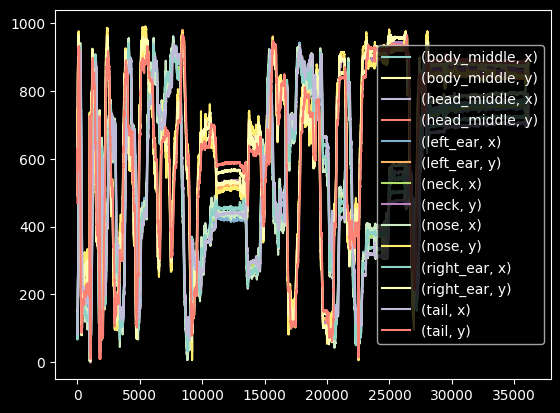

In [22]:
df_xy.plot().legend(loc='right')

In [23]:
df_flat = df_xy.copy()
df_flat.columns = df_flat.columns.map('_'.join)

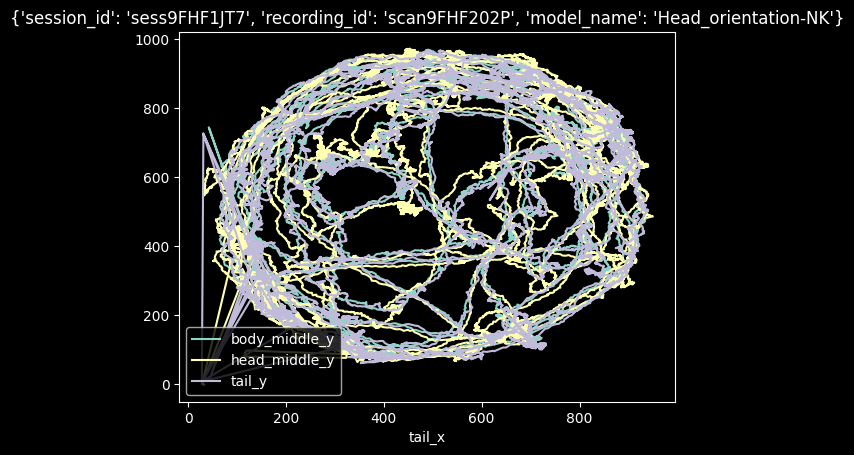

In [24]:
import matplotlib.pyplot as plt 
fig,ax=plt.subplots()
df_flat.plot(x='body_middle_x',y='body_middle_y',ax=ax)
df_flat.plot(x='head_middle_x',y='head_middle_y', ax=ax)
df_flat.plot(x='tail_x',y='tail_y', ax=ax)
plt.title(scan_key)
plt.show()

In [ ]:
destfolder = model.PoseEstimationTask.infer_output_dir(key)
destfolder

In [ ]:
from deeplabcut.utils.make_labeled_video import create_labeled_video

video_path = find_full_path( # Fetch the full video path
    get_dlc_root_data_dir(), ((model.VideoRecording.File & key).fetch1("file_path"))
)

config_paths = sorted( # Of configs in the project path, defer to the datajoint-saved
    list(
        find_full_path(
            get_dlc_root_data_dir(), ((model.Model & key).fetch1("project_path"))
        ).glob("*.y*ml")
    )
)

create_labeled_video( # Pass strings to label the video
    config=str(config_paths[-1]),
    videos=str(video_path),
    destfolder=str(destfolder),
)

# list(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).parent.glob("device*"))[0].glob("*.y*ml"))

In [ ]:
moviepath = str(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).glob("*53.mp4"))[0])
moviepath


In [ ]:
(model.VideoRecording.File & key).fetch1("file_path")

In [ ]:
list(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).parent.glob("device*"))[0].glob("*.y*ml"))